In [238]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy 

import predictive_coding as pc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


In [266]:
n_train = 10000
n_val = 500
n_test = 2000
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
dataset_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
dataset_eval = datasets.MNIST('./data', download=True, train=False, transform=transform)

# Randomly sample the train dataset
train_dataset = torch.utils.data.Subset(dataset_train, random.sample(range(len(dataset_train)), n_train))

# Randomly sample the val dataset
val_dataset, test_dataset, not_used = torch.utils.data.random_split(dataset_eval, [n_val, n_test, dataset_eval.__len__()-n_val-n_test])

print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 10000, val: 500, test: 2000


PC reversed direction

In [240]:
input_size = 28*28
hidden_size = 256
hidden2_size = 128
output_size = 10

# activation_fn = nn.ReLU
activation_fn = nn.Tanh

def get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn):
    return nn.Sequential(
        nn.Linear(input_size, hidden_size),
        pc.PCLayer(),
        activation_fn(),
        nn.Linear(hidden_size, hidden2_size),
        pc.PCLayer(),
        activation_fn(),
        nn.Linear(hidden2_size, output_size)
    )

pc_reversed = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
pc_reversed.train()
pc_reversed.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): PCLayer()
  (2): Tanh()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): PCLayer()
  (5): Tanh()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

In [241]:
T = 50                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.Adam         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.1}    # optimizer parameters for latent state x
update_p_at = 'last'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.01, "weight_decay":0.05} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_reversed = pc.PCTrainer(pc_reversed, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at,
)

def test_reversed(model, dataset, batch_size=1000):
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        _, predicted = torch.max(pred, -1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    model.train()
    return round(correct / total, 4)

Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Epoch 1 - Train acc: 0.205, Val acc: 0.196


Epoch 2: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Epoch 2 - Train acc: 0.304, Val acc: 0.302


Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch 3 - Train acc: 0.3985, Val acc: 0.382


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Epoch 4 - Train acc: 0.4275, Val acc: 0.41


Epoch 5: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Epoch 5 - Train acc: 0.5845, Val acc: 0.554


Epoch 6: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 6 - Train acc: 0.62, Val acc: 0.618


Epoch 7: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Epoch 7 - Train acc: 0.6905, Val acc: 0.676


Epoch 8: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch 8 - Train acc: 0.7255, Val acc: 0.696


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch 9 - Train acc: 0.735, Val acc: 0.734


Epoch 10: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Epoch 10 - Train acc: 0.741, Val acc: 0.734


Epoch 11: 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


Epoch 11 - Train acc: 0.761, Val acc: 0.76


Epoch 12: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch 12 - Train acc: 0.7695, Val acc: 0.768


Epoch 13: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Epoch 13 - Train acc: 0.7885, Val acc: 0.812


Epoch 14: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Epoch 14 - Train acc: 0.792, Val acc: 0.792


Epoch 15: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch 15 - Train acc: 0.791, Val acc: 0.796


Epoch 16: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch 16 - Train acc: 0.7835, Val acc: 0.778


Epoch 17: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch 17 - Train acc: 0.805, Val acc: 0.8


Epoch 18: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Epoch 18 - Train acc: 0.806, Val acc: 0.812


Epoch 19: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Epoch 19 - Train acc: 0.8065, Val acc: 0.814


Epoch 20: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch 20 - Train acc: 0.817, Val acc: 0.818


Epoch 21: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Epoch 21 - Train acc: 0.8175, Val acc: 0.818


Epoch 22: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Epoch 22 - Train acc: 0.8235, Val acc: 0.826


Epoch 23: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Epoch 23 - Train acc: 0.818, Val acc: 0.81


Epoch 24: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch 24 - Train acc: 0.8165, Val acc: 0.81


Epoch 25: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Epoch 25 - Train acc: 0.8205, Val acc: 0.802


Epoch 26: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Epoch 26 - Train acc: 0.827, Val acc: 0.822


Epoch 27: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch 27 - Train acc: 0.8205, Val acc: 0.802


Epoch 28: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


Epoch 28 - Train acc: 0.834, Val acc: 0.824


Epoch 29: 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


Epoch 29 - Train acc: 0.834, Val acc: 0.81


Epoch 30: 100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Epoch 30 - Train acc: 0.8205, Val acc: 0.814


Epoch 31: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Epoch 31 - Train acc: 0.8185, Val acc: 0.802


Epoch 32: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Epoch 32 - Train acc: 0.8345, Val acc: 0.82


Epoch 33: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Epoch 33 - Train acc: 0.8295, Val acc: 0.824


Epoch 34: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


Epoch 34 - Train acc: 0.837, Val acc: 0.824


Epoch 35: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch 35 - Train acc: 0.838, Val acc: 0.804


Epoch 36: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch 36 - Train acc: 0.8215, Val acc: 0.796


Epoch 37: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch 37 - Train acc: 0.835, Val acc: 0.808


Epoch 38: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch 38 - Train acc: 0.8405, Val acc: 0.812


Epoch 39: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch 39 - Train acc: 0.839, Val acc: 0.87


Epoch 40: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch 40 - Train acc: 0.8485, Val acc: 0.848


Epoch 41: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Epoch 41 - Train acc: 0.8505, Val acc: 0.848


Epoch 42: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch 42 - Train acc: 0.848, Val acc: 0.848


Epoch 43: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch 43 - Train acc: 0.8425, Val acc: 0.86


Epoch 44: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch 44 - Train acc: 0.844, Val acc: 0.852


Epoch 45: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch 45 - Train acc: 0.8355, Val acc: 0.84


Epoch 46: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch 46 - Train acc: 0.828, Val acc: 0.84


Epoch 47: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Epoch 47 - Train acc: 0.838, Val acc: 0.83


Epoch 48: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Epoch 48 - Train acc: 0.843, Val acc: 0.854


Epoch 49: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch 49 - Train acc: 0.848, Val acc: 0.838


Epoch 50: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch 50 - Train acc: 0.842, Val acc: 0.834
Test accuracy: 0.839


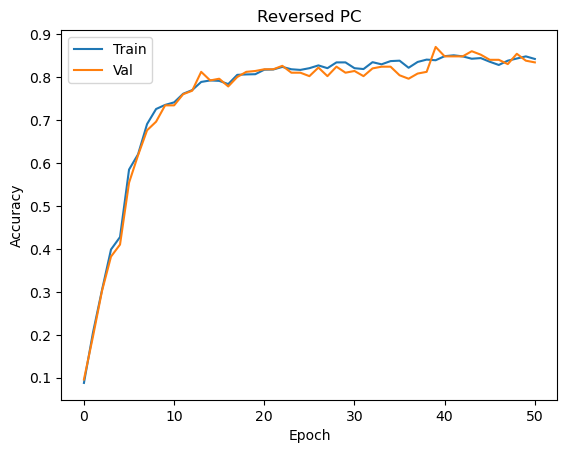

In [242]:
epochs = 50
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

CE_loss = nn.CrossEntropyLoss()
loss_fn = lambda output, _target: CE_loss(output, _target)

best_val_acc = 0
best_model = copy.deepcopy(pc_reversed.state_dict())

train_acc = [test_reversed(pc_reversed, test_dataset)]
val_acc = [test_reversed(pc_reversed, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        trainer_reversed.train_on_batch(inputs=data, loss_fn=loss_fn, loss_fn_kwargs={'_target':label}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    train_acc.append(test_reversed(pc_reversed, test_dataset))
    val_acc.append(test_reversed(pc_reversed, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_reversed.state_dict())
    print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Reversed PC')
    
test_model = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_reversed(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')

PC normal direction

In [284]:
input_size = 10
hidden_size = 256
hidden2_size = 256
output_size = 28*28

# activation_fn = nn.ReLU
activation_fn = nn.Tanh

pc_normal = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
pc_normal.train()
pc_normal.to(device)

def loss_fn_normal(output, _target):
    return 0.5*(output - _target).pow(2).sum()

In [285]:
T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0., "betas":(0.9,0.999)} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_normal = pc.PCTrainer(pc_normal, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features, offset=0.):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(offset*torch.ones(out_features) if offset is not None else 2*np.sqrt(out_features)*torch.rand(out_features)-np.sqrt(out_features), requires_grad=True)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same


def test_normal(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        BiasLayer(10, offset=0.),
        pc.PCLayer(),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model   
    trainer_normal_test = pc.PCTrainer(test_model, 
        T = 100, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        
        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)

Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Epoch 1 - Train acc: 0.7645, Val acc: 0.738


Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Epoch 2 - Train acc: 0.8115, Val acc: 0.764


Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Epoch 3 - Train acc: 0.838, Val acc: 0.788


Epoch 4: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Epoch 4 - Train acc: 0.8405, Val acc: 0.794


Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Epoch 5 - Train acc: 0.859, Val acc: 0.806


Epoch 6: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Epoch 6 - Train acc: 0.8545, Val acc: 0.802


Epoch 7: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Epoch 7 - Train acc: 0.8585, Val acc: 0.812


Epoch 8: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Epoch 8 - Train acc: 0.858, Val acc: 0.81


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Epoch 9 - Train acc: 0.8595, Val acc: 0.802


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Epoch 10 - Train acc: 0.852, Val acc: 0.806
Test accuracy: 0.8585


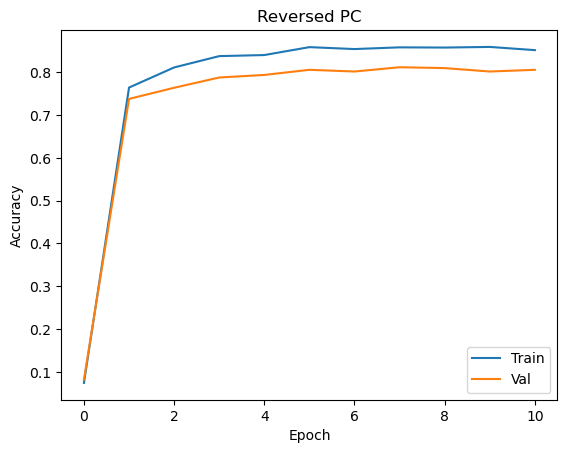

In [286]:
epochs = 10
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_normal.state_dict())

train_acc = [test_normal(pc_normal, test_dataset)]
val_acc = [test_normal(pc_normal, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        # labels to one-hot
        labels_one_hot = F.one_hot(label).float()
        trainer_normal.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    train_acc.append(test_normal(pc_normal, test_dataset))
    val_acc.append(test_normal(pc_normal, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_normal.state_dict())
    print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Normal PC')
    
test_model = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_normal(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')

V -model

In [407]:

x_optm = [optim.Adam, optim.SGD]
lr_x = [1e-3, 1e-2, 1e-1, 1]
p_optm = [optim.Adam, optim.SGD]
lr_p = [1e-3, 1e-2, 1e-1, 1]
weight_decay = [0, 1e-3, 1e-2, 1e-1]
activation_fns = [nn.ReLU, nn.Tanh]
best_val_acc_tuning = 0
best_params = None

for lr_x_ in tqdm(lr_x):
    for lr_p_ in lr_p:
        for weight_decay_ in weight_decay:
            for optimizer_x_fn in x_optm:
                for optimizer_p_fn in p_optm:
                    for activation_fn_ in activation_fns:
                        input_size = 10
                        latent_size = 60
                        hidden_size = 256
                        hidden2_size = 256
                        output_size = 28*28

                        # activation_fn = nn.ReLU
                        # # activation_fn = nn.Tanh


                        class PC_V_model(nn.Module):
                            def __init__(self, input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn):
                                super(PC_V_model, self).__init__()
                                self.head = nn.Sequential(
                                    BiasLayer(latent_size, offset=None),
                                    pc.PCLayer(),
                                )
                                self.encoder = nn.Sequential(
                                    nn.Linear(latent_size, hidden_size),
                                    pc.PCLayer(),
                                    activation_fn(),
                                    nn.Linear(hidden_size, hidden2_size),
                                    pc.PCLayer(),
                                    activation_fn(),
                                    nn.Linear(hidden2_size, output_size)
                                )
                                self.decoder = nn.Sequential(
                                    nn.Linear(latent_size, input_size),
                                )
                                
                            def forward(self, x):
                                latent = self.head(x)
                                return torch.cat((self.encoder(latent), self.decoder(latent)), dim=1)


                        pc_v_model = PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
                        pc_v_model.train()
                        pc_v_model.to(device)


                        def loss_fn_v_model(output, _image, _label):
                            return 0.5*(output[:,:_image.shape[1]] - _image).pow(2).sum() + 0.1*CE_loss(output[:,_image.shape[1]:], _label)
                        T = 20                             # number of inference iterations
                        update_x_at = 'all'                 # update latent state x at every iteration
                        optimizer_x_fn = optimizer_x_fn         # optimizer for latent state x
                        optimizer_x_kwargs = {'lr': lr_x_}    # optimizer parameters for latent state x
                        update_p_at = 'last'                # update parameters p at the last iteration
                        optimizer_p_fn = optimizer_p_fn         # optimizer for parameters p
                        optimizer_p_kwargs = {"lr": lr_p_, "weight_decay":weight_decay_} # optimizer parameters for parameters p
                        plot_progress_at = []            # plot progress every inference iterations

                        trainer_v_model = pc.PCTrainer(pc_v_model, 
                            T = T, 
                            update_x_at = update_x_at, 
                            optimizer_x_fn = optimizer_x_fn,
                            optimizer_x_kwargs = optimizer_x_kwargs,
                            update_p_at = update_p_at,   
                            optimizer_p_fn = optimizer_p_fn,
                            optimizer_p_kwargs = optimizer_p_kwargs,
                            plot_progress_at= plot_progress_at
                        )

                        # trainer_v_model.set_optimizer_p(optim.Adam(pc_v_model.decoder.parameters(), lr=0.0001, weight_decay=0.01, betas=(0.9,0.999)))

                        def test_v_model(model, dataset, batch_size=1000):
                            test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

                            # make pc_trainer for test_model   
                            trainer_test = pc.PCTrainer(model, 
                                T = 200, 
                                update_x_at = update_x_at, 
                                optimizer_x_fn = optimizer_x_fn,
                                optimizer_x_kwargs = optimizer_x_kwargs,
                                update_p_at = "never",   
                                optimizer_p_fn = optimizer_p_fn,
                                optimizer_p_kwargs = optimizer_p_kwargs,
                                plot_progress_at= plot_progress_at
                            )

                            correct_count, all_count = 0., 0.
                            for data, labels in (test_loader):
                                pseudo_input = torch.zeros(data.shape[0], latent_size)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                labels_one_hot = F.one_hot(labels).float()
                                # MAP inference
                                results = trainer_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
                                output = results["outputs"][-1]
                                pred = torch.max(output[:, data.shape[1]:], dim=1)
                                correct = (pred.indices == labels).long()
                                correct_count += correct.sum()
                                all_count += correct.size(0)
                            return round((correct_count / all_count).item(), 4)
                        epochs = 10
                        batch_size = 512
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                        best_val_acc = 0
                        best_model = copy.deepcopy(pc_v_model.state_dict())

                        train_acc = [test_v_model(pc_v_model, test_dataset)]
                        val_acc = [test_v_model(pc_v_model, val_dataset)]
                        for epoch in range(epochs):
                            for data, labels in train_loader:
                                pseudo_input = torch.zeros(data.shape[0], latent_size)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                labels_one_hot = F.one_hot(labels).float()
                                trainer_v_model.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
                            train_acc.append(test_v_model(pc_v_model, test_dataset))
                            val_acc.append(test_v_model(pc_v_model, val_dataset))
                            if val_acc[-1] > best_val_acc:
                                best_val_acc = val_acc[-1]
                                best_model = copy.deepcopy(pc_v_model.state_dict())
                            # print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')

                        if best_val_acc > best_val_acc_tuning:
                            print(f'Best val acc: {best_val_acc}, Best params: "lr_x": {lr_x_}, "lr_p": {lr_p_}, "weight_decay": {weight_decay_}, "activation_fn": {activation_fn_}, "optimizer_x_fn": {optimizer_x_fn}, "optimizer_p_fn": {optimizer_p_fn}')
                            best_val_acc_tuning = best_val_acc
                            best_params = {"lr_x": lr_x_, "lr_p": lr_p_, "weight_decay": weight_decay_}

print(f'Best val acc: {best_val_acc_tuning}, Best params: {best_params}')

  0%|          | 0/4 [00:00<?, ?it/s]

Best val acc: 0.176, Best params: {"lr_x": lr_x_, "lr_p": lr_p_, "weight_decay": weight_decay_}


  0%|          | 0/4 [03:55<?, ?it/s]


KeyboardInterrupt: 